In [5]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.data import Data

data_list = torch.load("../../data/train_data/edge_features_with_net_flow/datalist_batch_1.pt")

class EdgeFeatures:
    VOL_BASE_CASE = 0
    CAPACITY_BASE_CASE = 1
    CAPACITY_REDUCTION = 2
    FREESPEED = 3
    HIGHWAY = 4
    LENGTH = 5
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Test the EIGN edge aggregation functionality
import sys
import os
sys.path.append('../../scripts')

# Import the new function
from data_preprocessing.process_simulations_for_gnn import create_aggregated_edges_for_eign
from data_preprocessing.help_functions import highway_mapping
import geopandas as gpd
import pandas as pd
import numpy as np

# Create a simple test dataset
test_data = {
    'link': [1, 2, 3],
    'from_node': ['A', 'B', 'B'],
    'to_node': ['B', 'A', 'C'], 
    'vol_car': [100, 80, 150],
    'capacity': [2000, 2000, 3000],
    'length': [1000, 1000, 1500],
    'freespeed': [50, 50, 60],
    'highway': ['primary', 'primary', 'secondary'],
    'modes': ['car,bus', 'car,bus', 'car'],
    'geometry': [None, None, None, None]  # Will be created below
}

# Create simple line geometries
from shapely.geometry import LineString
test_data['geometry'] = [
    LineString([(0, 0), (1, 0)]),  # A->B
    LineString([(1, 0), (0, 0)]),  # B->A (reverse of first)
    LineString([(1, 0), (2, 1)]),  # B->C
]

# Create GeoDataFrame
test_gdf = gpd.GeoDataFrame(test_data)
test_gdf = test_gdf.set_crs("EPSG:4326")

print("Original test data:")
print(test_gdf[['from_node', 'to_node', 'vol_car', 'highway']].to_string())
print(f"\nTotal edges in original data: {len(test_gdf)}")

try:
    # Test the aggregation function
    edge_index, features, edge_is_directed, positions = create_aggregated_edges_for_eign(test_gdf)
    
    print(f"\nAfter aggregation:")
    print(f"Number of aggregated edges: {edge_index.shape[1]}")
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Edge directions (is_directed): {edge_is_directed}")
    print(f"Net flow values: {features['net_flow']}")
    print(f"Volume base case: {features['vol_base_case']}")
    print(f"Highway types: {features['highway']}")
    
    # Check if we correctly aggregated A<->B bidirectional edge
    print(f"\nSuccessfully aggregated {len(test_gdf)} original edges into {edge_index.shape[1]} aggregated edges!")
    
    # Verify the net flow calculation for A<->B
    # Should be vol_car(A->B) - vol_car(B->A) = 100 - 80 = 20
    if len(features['net_flow']) > 0:
        print(f"Net flow for first edge: {features['net_flow'][0]} (expected: 20 for A<->B)")
    
except Exception as e:
    print(f"Error testing aggregation function: {e}")
    import traceback
    traceback.print_exc()

Original test data:
  from_node to_node  vol_car    highway
0         A       B      100    primary
1         B       A       80    primary
2         B       C      150  secondary

Total edges in original data: 3

After aggregation:
Number of aggregated edges: 2
Edge index shape: torch.Size([2, 2])
Edge directions (is_directed): tensor([False,  True])
Net flow values: tensor([ 20., 150.])
Volume base case: tensor([100., 150.])
Highway types: tensor([1., 2.])

Successfully aggregated 3 original edges into 2 aggregated edges!
Net flow for first edge: 20.0 (expected: 20 for A<->B)


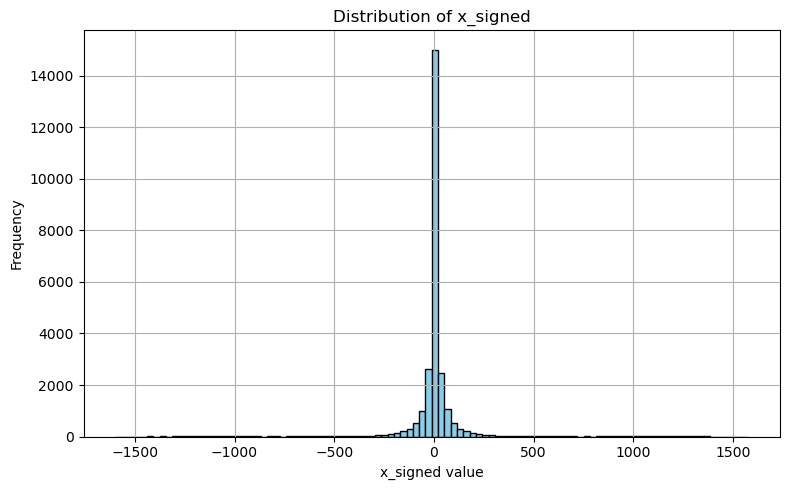

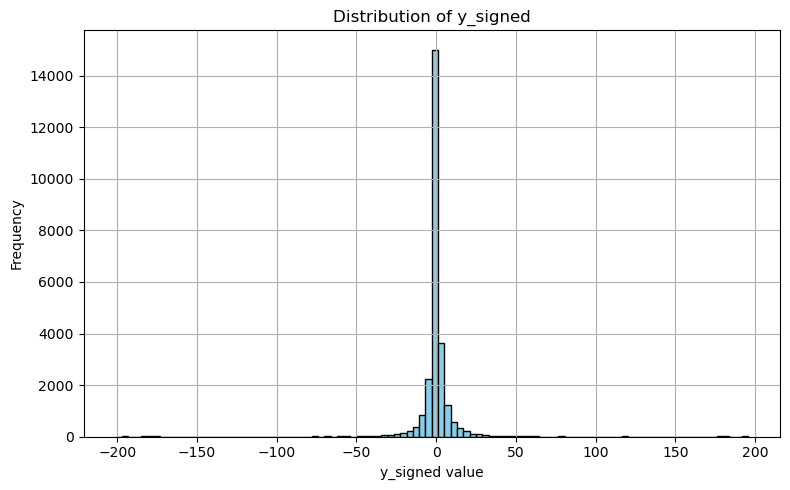

In [7]:
import matplotlib.pyplot as plt

# Extract x_signed and convert to numpy
x_signed = data_list[0].x_signed.squeeze().numpy()  # shape: (31635,)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(x_signed, bins=100, color="skyblue", edgecolor="black")
plt.title("Distribution of x_signed")
plt.xlabel("x_signed value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract y_signed and convert to numpy
y_signed = data_list[0].y_signed.squeeze().numpy()  # shape: (31635,)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(y_signed, bins=100, color="skyblue", edgecolor="black")
plt.title("Distribution of y_signed")
plt.xlabel("y_signed value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

PyTorch Geometric (PyG) data batches are saved in the `result_path` as `.pt` tensor files. Each sample is a homogenous graph (representing a scenario as decribed above) with the following attributes per node (road segment):
- `x`: Node features:
    - Volume Base Case
    - Capacity Base Case
    - Capacity Reduction
    - Maximum Speed
    - Road Type
    - Length
    - And additionally, if `use_allowed_modes` is `True`, then booleans indicating whether `Car`, `Bus`, `Public Transport`, `Train`, `Rail`, and `Subway` are allowed on the road segment.
- `y`: Target for the GNN, difference in traffic volume between the base case and the simulation run (with policy applied).
- `pos`: x and y coordinates of the start, middle, and end of the road segment.

And the following attributes for the entire graph:
- `edge_index`: Edges of the graph, defined by the start and end nodes of each edge.
- `mode_stats_diff`: Difference in travel mode statistics between the base case and the simulation run (with policy applied).
- `mode_stats_diff_per`: `mode_stats_diff` in percentage (compared to the base case).

In [8]:
import torch
import numpy as np

# Function to check for NaN and inf in tensors
def check_tensor_health(tensor, name):
    """Check a tensor for NaN and inf values"""
    if tensor is None:
        print(f"{name}: None")
        return True
    
    has_nan = torch.isnan(tensor).any().item()
    has_inf = torch.isinf(tensor).any().item()
    
    if has_nan or has_inf:
        print(f"❌ {name}: shape={tensor.shape}, has_nan={has_nan}, has_inf={has_inf}")
        if has_nan:
            nan_count = torch.isnan(tensor).sum().item()
            print(f"   NaN count: {nan_count}")
        if has_inf:
            inf_count = torch.isinf(tensor).sum().item()
            pos_inf_count = torch.isposinf(tensor).sum().item()
            neg_inf_count = torch.isneginf(tensor).sum().item()
            print(f"   Inf count: {inf_count} (pos: {pos_inf_count}, neg: {neg_inf_count})")
        return False
    else:
        print(f"✅ {name}: shape={tensor.shape}, clean")
        return True

# Check all data in data_list
print(f"Checking {len(data_list)} graphs for NaN/inf values...\n")

all_clean = True
for i, data in enumerate(data_list):
    print(f"--- Graph {i+1}/{len(data_list)} ---")
    
    # Check all attributes of the PyG Data object
    for attr_name in dir(data):
        if not attr_name.startswith('_'):  # Skip private attributes
            attr_value = getattr(data, attr_name, None)
            
            # Only check tensor attributes
            if isinstance(attr_value, torch.Tensor):
                is_clean = check_tensor_health(attr_value, f"{attr_name}")
                all_clean = all_clean and is_clean
    
    print()  # Empty line between graphs
    
    # Break early if checking many graphs
    if i >= 4:  # Only check first 5 graphs to avoid too much output
        print(f"... (showing first 5 graphs only)")
        break

print(f"\n{'='*50}")
if all_clean:
    print("🎉 All checked tensors are clean (no NaN or inf values)!")
else:
    print("⚠️  Found NaN or inf values in the data!")

# Additional summary statistics
print(f"\n--- Summary Statistics for First Graph ---")
if len(data_list) > 0:
    first_data = data_list[0]
    
    # Check key tensors with more detail
    key_tensors = ['x', 'y', 'edge_index', 'pos']
    for tensor_name in key_tensors:
        if hasattr(first_data, tensor_name):
            tensor = getattr(first_data, tensor_name)
            if isinstance(tensor, torch.Tensor):
                print(f"{tensor_name}: min={tensor.min().item():.4f}, max={tensor.max().item():.4f}, mean={tensor.float().mean().item():.4f}")
    
    # Check for signed versions if they exist
    if hasattr(first_data, 'x_signed'):
        x_signed = first_data.x_signed
        print(f"x_signed: min={x_signed.min().item():.4f}, max={x_signed.max().item():.4f}, mean={x_signed.float().mean().item():.4f}")
    
    if hasattr(first_data, 'y_signed'):
        y_signed = first_data.y_signed
        print(f"y_signed: min={y_signed.min().item():.4f}, max={y_signed.max().item():.4f}, mean={y_signed.float().mean().item():.4f}")

Checking 10 graphs for NaN/inf values...

--- Graph 1/10 ---
✅ edge_index: shape=torch.Size([2, 25663]), clean
✅ pos: shape=torch.Size([0]), clean
✅ x: shape=torch.Size([25663, 6]), clean
✅ y: shape=torch.Size([25663, 1]), clean

--- Graph 2/10 ---
✅ edge_index: shape=torch.Size([2, 25663]), clean
✅ pos: shape=torch.Size([0]), clean
✅ x: shape=torch.Size([25663, 6]), clean
✅ y: shape=torch.Size([25663, 1]), clean

--- Graph 3/10 ---
✅ edge_index: shape=torch.Size([2, 25663]), clean
✅ pos: shape=torch.Size([0]), clean
✅ x: shape=torch.Size([25663, 6]), clean
✅ y: shape=torch.Size([25663, 1]), clean

--- Graph 4/10 ---
✅ edge_index: shape=torch.Size([2, 25663]), clean
✅ pos: shape=torch.Size([0]), clean
✅ x: shape=torch.Size([25663, 6]), clean
✅ y: shape=torch.Size([25663, 1]), clean

--- Graph 5/10 ---
✅ edge_index: shape=torch.Size([2, 25663]), clean
✅ pos: shape=torch.Size([0]), clean
✅ x: shape=torch.Size([25663, 6]), clean
✅ y: shape=torch.Size([25663, 1]), clean

... (showing first

/home/dnguyen/miniforge3/envs/traffic-gnn/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'num_faces' is deprecated, use 'data.face.size(-1)' instead
  warnings.warn(out)


RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.